In [3]:
# 从sklearn 调入所需要的包
# from sklearn import datasets

import os
import json
import gc
# os.system('pip install numba')
from numba import jit
#tqdm
# os.system('pip install tqdm')
from tqdm import tqdm_notebook
from tqdm import tqdm

#Integrated model
# os.system('pip install lightgbm')
import lightgbm as lgb
# os.system('pip install catboost==0.15.2')
import catboost as cbt
# os.system('pip install xgboost')
# import xgboost as xgb

#base import 
import numpy as np
import pandas as pd

# about sklearn
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler as std
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import f1_score
#about time
import time
import datetime 
from datetime import datetime, timedelta

#Garbage collection
import gc
# scipy
from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats
import scipy.spatial.distance as dist
#other
from collections import Counter 
from statistics import mode 
    #warning
import warnings
warnings.filterwarnings("ignore")
import json 
import math
from itertools import product
import ast
from sklearn.model_selection import train_test_split #数据分隔出训练集和验证集
import lightgbm as lgb
import numpy as np 
import pandas as pd
#导入精度和召回
from sklearn.metrics import precision_score, recall_score
import lightgbm as lgb
pd.set_option('display.max_columns',None)

In [4]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


In [5]:
path='./'
train = pd.read_csv(path+'input/happiness_train_complete.csv',encoding='gbk')
test = pd.read_csv(path+'input/happiness_test_complete.csv',encoding='gbk')
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Columns: 140 entries, id to public_service_9
dtypes: float64(25), int64(111), object(4)
memory usage: 8.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2968 entries, 0 to 2967
Columns: 139 entries, id to public_service_9
dtypes: float64(23), int64(112), object(4)
memory usage: 3.1+ MB
None


In [6]:
train.describe()

,id,happiness,survey_type,province,city,county,gender,birth,nationality,religion,religion_freq,edu,edu_status,edu_yr,income,political,join_party,floor_area,property_0,property_1,property_2,property_3,property_4,property_5,property_6,property_7,property_8,height_cm,weight_jin,health,health_problem,depression,hukou,hukou_loc,media_1,media_2,media_3,media_4,media_5,media_6,leisure_1,leisure_2,leisure_3,leisure_4,leisure_5,leisure_6,leisure_7,leisure_8,leisure_9,leisure_10,leisure_11,leisure_12,socialize,relax,learn,social_neighbor,social_friend,socia_outing,equity,class,class_10_before,class_10_after,class_14,work_exper,work_status,work_yr,work_type,work_manage,insur_1,insur_2,insur_3,insur_4,family_income,family_m,family_status,house,car,invest_0,invest_1,invest_2,invest_3,invest_4,invest_5,invest_6,invest_7,invest_8,son,daughter,minor_child,marital,marital_1st,s_birth,marital_now,s_edu,s_political,s_hukou,s_income,s_work_exper,s_work_status,s_work_type,f_birth,f_edu,f_political,f_work_14,m_birth,m_edu,m_political,m_work_14,status_peer,status_3_before,view,inc_ability,inc_exp,trust_1,trust_2,trust_3,trust_4,trust_5,trust_6,trust_7,trust_8,trust_9,trust_10,trust_11,trust_12,trust_13,neighbor_familiarity,public_service_1,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9
count,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000,8000.000000,8000.00000,8000.000000,8000.000000,8000.000000,6880.000000,6028.000000,8.000000e+03,8000.000000,824.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,7996.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000,7204.000000,7204.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,2951.000000,2951.000000,2951.000000,2951.000000,8000.000000,8000.000000,8000.000000,8000.000000,7.999000e+03,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000,8000.000000,8000.000000,8000.000000,8000.0,8000.000000,8000.000000,8000.000000,8000.000000,6934.000000,8000.000000,7172.000000,6282.000000,6230.000000,6282.000000,6282.000000,6282.000000,6.282000e+03,6282.000000,2565.000000,2565.000000,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000,8000.000000,8000.000000,8000.000000,8000.00000,8000.000000,8.000000e+03,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000,8000.000000,8000.000000
mean,4000.50000,3.850125,1.405500,15.155375,42.564750,70.619000,1.53000,1964.707625,1.37350,0.772250,1.427250,4.878375,3.505523,1574.742867,3.330734e+04,1.317750,1785.067961,115.302954,0.007875,0.473000,0.268500,0.101125,0.102750,0.023625,0.004000,0.022500,0.13600,163.989750,121.575625,3.598500,3.786250,3.819375,1.893750,1.375938,1.891875,1.710125,1.797375,3.915375,2.368625,1.60575,1.625250,4.496500,3.452375,3.762125,4.402625,3.756250,3.554000,3.591500,3.521500,4.713500,4.482125,3.427375,2.790625,3.291000,1.92650,3.474181,3.622432,1.825500,3.135125,4.192250,3.439625,4.445125,2.925375,2.979750,3.155202,14.500508,0.906811,2.652321,1.062125,1.232875,1.820875,1.835625,6.776050e+04,2.882500,2.595875,1.063625,1.817125,0.014875,0.909500,0.06150,0.020750,0.004750,0.001875,0.0,0.000750,0.000750,0.924375,0.767125,0.456879,3.234375,1825.481177,1963.963069,1868.025522,4.614454,1.319007,1.842566,2.836550e+04,2.838427,3.175828,0.963743,1108.42025,2.043500,1.079125,2.744625,1150.667250,1.550500,0.89900

In [7]:
test.describe()

,id,survey_type,province,city,county,gender,birth,nationality,religion,religion_freq,edu,edu_status,edu_yr,income,political,join_party,floor_area,property_0,property_1,property_2,property_3,property_4,property_5,property_6,property_7,property_8,height_cm,weight_jin,health,health_problem,depression,hukou,hukou_loc,media_1,media_2,media_3,media_4,media_5,media_6,leisure_1,leisure_2,leisure_3,leisure_4,leisure_5,leisure_6,leisure_7,leisure_8,leisure_9,leisure_10,leisure_11,leisure_12,socialize,relax,learn,social_neighbor,social_friend,socia_outing,equity,class,class_10_before,class_10_after,class_14,work_exper,work_status,work_yr,work_type,work_manage,insur_1,insur_2,insur_3,insur_4,family_income,family_m,family_status,house,car,invest_0,invest_1,invest_2,invest_3,invest_4,invest_5,invest_6,invest_7,invest_8,son,daughter,minor_child,marital,marital_1st,s_birth,marital_now,s_edu,s_political,s_hukou,s_income,s_work_exper,s_work_status,s_work_type,f_birth,f_edu,f_political,f_work_14,m_birth,m_edu,m_political,m_work_14,status_peer,status_3_before,view,inc_ability,inc_exp,trust_1,trust_2,trust_3,trust_4,trust_5,trust_6,trust_7,trust_8,trust_9,trust_10,trust_11,trust_12,trust_13,neighbor_familiarity,public_service_1,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9
count,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2519.000000,2184.000000,2968.000000,2968.000000,302.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2667.000000,2667.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,1078.000000,1078.000000,1079.000000,1079.000000,2968.000000,2968.000000,2968.000000,2968.000000,2.968000e+03,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2586.000000,2968.000000,2667.000000,2319.000000,2291.000000,2319.000000,2319.000000,2319.000000,2.319000e+03,2319.000000,959.000000,959.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2.968000e+03,2968.000000,2968.000000,2968.00000,2968.000000,2968.00000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000
mean,9484.500000,1.422507,15.295485,42.943059,71.242588,1.537062,1964.320081,1.350404,0.772574,1.434636,4.801550,3.477173,1598.595238,24764.746968,1.341644,1750.447020,117.819340,0.008423,0.468666,0.263477,0.100067,0.107480,0.030323,0.004043,0.022237,0.131065,163.677898,120.819407,3.604784,3.819407,3.791105,1.879380,1.358154,1.889825,1.705526,1.798854,3.924865,2.312668,1.573113,1.604784,4.550876,3.432615,3.762129,4.422170,3.748315,3.566375,3.569407,3.491240,4.704852,4.509771,3.510445,2.824124,3.314690,1.919811,3.394076,3.566554,1.776954,3.122978,4.210916,3.463612,4.442722,2.920485,2.995620,3.116883,14.300557,0.911956,2.601483,1.066712,1.245620,1.823787,1.838275,6.244181e+04,2.879717,2.574124,1.081199,1.820081,0.016173,0.909030,0.056941,0.025606,0.005054,0.001011,0.000337,0.000674,0.000337,0.931267,0.818396,0.435035,3.263140,1841.760030,1963.881414,1888.013095,4.590341,1.301423,1.768435,2.768073e+04,2.806813,3.216893,0.989572,1134.498652,1.923854,1.117251,2.715296,1166.414420,1.495957,0.884434,4.050

In [8]:
train.corr()

,id,happiness,survey_type,province,city,county,gender,birth,nationality,religion,religion_freq,edu,edu_status,edu_yr,income,political,join_party,floor_area,property_0,property_1,property_2,property_3,property_4,property_5,property_6,property_7,property_8,height_cm,weight_jin,health,health_problem,depression,hukou,hukou_loc,media_1,media_2,media_3,media_4,media_5,media_6,leisure_1,leisure_2,leisure_3,leisure_4,leisure_5,leisure_6,leisure_7,leisure_8,leisure_9,leisure_10,leisure_11,leisure_12,socialize,relax,learn,social_neighbor,social_friend,socia_outing,equity,class,class_10_before,class_10_after,class_14,work_exper,work_status,work_yr,work_type,work_manage,insur_1,insur_2,insur_3,insur_4,family_income,family_m,family_status,house,car,invest_0,invest_1,invest_2,invest_3,invest_4,invest_5,invest_6,invest_7,invest_8,son,daughter,minor_child,marital,marital_1st,s_birth,marital_now,s_edu,s_political,s_hukou,s_income,s_work_exper,s_work_status,s_work_type,f_birth,f_edu,f_political,f_work_14,m_birth,m_edu,m_political,m_work_14,status_peer,status_3_before,view,inc_ability,inc_exp,trust_1,trust_2,trust_3,trust_4,trust_5,trust_6,trust_7,trust_8,trust_9,trust_10,trust_11,trust_12,trust_13,neighbor_familiarity,public_service_1,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9
id,1.000000,0.009560,-0.011345,-0.010624,-0.008390,-0.008109,0.021515,-0.000808,0.000470,0.002805,0.003557,0.016327,0.003359,0.014581,0.001647,0.010574,-0.002934,-0.004246,-0.009353,-0.028030,-0.004781,0.002373,-0.001862,0.010128,-0.000587,0.026434,0.013666,-0.017512,-0.024580,0.008466,0.003982,0.010735,0.018732,0.008080,0.010098,0.023473,0.011024,-0.002340,0.004755,0.007709,0.020170,-0.011373,-0.005153,-0.017008,-0.007150,-0.003008,-0.022876,-0.000981,-0.014163,-0.003011,-0.015646,0.001346,0.002917,0.008571,0.017032,-0.019992,-0.023678,0.006902,0.000947,0.008587,0.023512,-0.000649,0.018517,0.016033,0.021452,-0.026075,0.004710,0.003727,0.009830,-0.001802,0.008914,0.008087,0.016315,-0.007322,0.013052,-0.005744,-0.014820,-0.016138,-0.008354,0.013845,0.010483,0.012549,0.009432,NaN,-0.010220,-0.000696,-0.015193,0.019023,0.007368,0.007040,-0.015741,0.002333,-0.007180,0.028718,0.023786,0.006436,0.006227,-0.012352,-0.001302,-0.005825,-0.005900,0.011180,-0.018697,0.005200,0.002227,0.007890,-0.007184,0.004606,-0.004911,0.015799,0.015835,-0.014626,-0.007919,0.009002,-0.016133,-0.013565,-0.018801,-0.007583,-0.021084,-0.016482,0.002847,-0.016349,0.002837,-0.010224,-0.004779,-0.021787,-0.009623,0.010937,-0.001514,0.005270,0.006742,0.017411,0.011626,0.001778,0.007313,0.006183
happiness,0.009560,1.000000,-0.017043,-0.007333,-0.009733,-0.007544,0.022016,-0.007805,-0.018928,0.063539,0.002296,0.102945,0.040527,0.067897,0.024056,0.094677,0.052190,0.046945,-0.080732,-0.009040,0.040867,0.031487,0.016762,0.014323,0.010124,-0.011700,-0.042342,0.030380,0.074584,0.246979,0.182414,0.299933,0.057366,0.017320,0.097351,0.104797,0.099607,0.111960,0.060815,0.072850,-0.048054,0.025863,-0.035774,-0.055699,-0.005452,-0.051344,-0.030730,-0.059650,-0.106339,0.033427,0.017835,-0.035725,0.103588,0.134761,0.116214,0.001900,-0.056332,0.094388,0.245552,0.267328,0.152986,0.179701,0.110829,0.002564,0.026440,-0.009747,0.065813,0.020994,-0.002966,-0.017432,0.040919,0.037924,0.047654,0.054821,0.235988,0.103013,-0.012826,-0.045309,-0.026244,0.045332,0.038210,0.026539,0.010004,NaN,0.004377,0.009244,0.014468,0.059761,0.023391,-0.026026,0.071274,-0.007047,0.055198,0.134521,0.097660,0.085194,0.016738,-0.001833,0.046034,0.045890,0.048827,0.050413,0.018743,0.027535,0.054301,0.059320,0.011622,0.036026,-0.084743,-0.022892,0.112572,0.002179,-0.002001,0.084272,0.070737,-0.002978,-0.008420,0.137646,0.048084,0.075798,0.066609,0.058842,0.066100,0.001981,0.053695,0.060008,0.059083,0.116263,0.136942,0.142208,0.128396,0.133480,0.157128,0.147594,0.125048,0.132335
survey_type,-0.011345,-0.017043,1.000000,0.090110,0.087598,0.092077,-0.018017,-0.

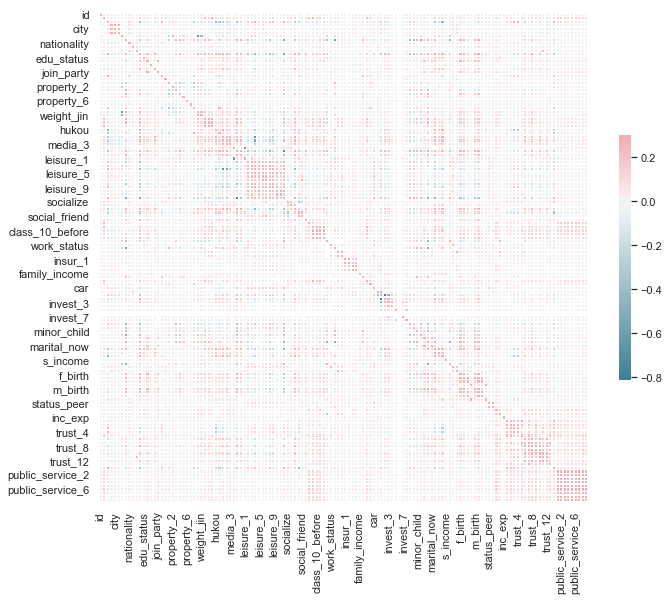

In [9]:
#查看特征直接的相关性
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="white")
# 计算训练集的相关性
corr = train.corr()
# 设置 matplotlib f的尺寸
f, ax = plt.subplots(figsize=(11, 9))
# 生成自定义的散色图
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# 为热力图设置长宽比
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

####  训练集和测试集的形状：

In [10]:
print("训练集的形状为：{}".format(train.shape),"训练集的形状为：{}".format(test.shape))

训练集的形状为：(8000, 140) 训练集的形状为：(2968, 139)


In [11]:
train.head()

,id,happiness,survey_type,province,city,county,survey_time,gender,birth,nationality,religion,religion_freq,edu,edu_other,edu_status,edu_yr,income,political,join_party,floor_area,property_0,property_1,property_2,property_3,property_4,property_5,property_6,property_7,property_8,property_other,height_cm,weight_jin,health,health_problem,depression,hukou,hukou_loc,media_1,media_2,media_3,media_4,media_5,media_6,leisure_1,leisure_2,leisure_3,leisure_4,leisure_5,leisure_6,leisure_7,leisure_8,leisure_9,leisure_10,leisure_11,leisure_12,socialize,relax,learn,social_neighbor,social_friend,socia_outing,equity,class,class_10_before,class_10_after,class_14,work_exper,work_status,work_yr,work_type,work_manage,insur_1,insur_2,insur_3,insur_4,family_income,family_m,family_status,house,car,invest_0,invest_1,invest_2,invest_3,invest_4,invest_5,invest_6,invest_7,invest_8,invest_other,son,daughter,minor_child,marital,marital_1st,s_birth,marital_now,s_edu,s_political,s_hukou,s_income,s_work_exper,s_work_status,s_work_type,f_birth,f_edu,f_political,f_work_14,m_birth,m_edu,m_political,m_work_14,status_peer,status_3_before,view,inc_ability,inc_exp,trust_1,trust_2,trust_3,trust_4,trust_5,trust_6,trust_7,trust_8,trust_9,trust_10,trust_11,trust_12,trust_13,neighbor_familiarity,public_service_1,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9
0,1,4,1,12,32,59,2015/8/4 14:18,1,1959,1,1,1,11,NaN,4.0,-2.0,20000,1,NaN,45.0,0,1,0,0,0,0,0,0,0,NaN,176,155,3,2,5,5,2.0,4,2,5,5,4,3,1,4,3,1,2,3,4,1,4,5,4,1,2,4,3,3.0,3.0,2,3,3,3,3,1,1,3.0,30.0,1.0,2.0,1,1,1,2,60000.0,2,2,1,2,0,1,0,0,0,0,0,0,0,NaN,1,0,0.0,3,1984.0,1958.0,1984.0,6.0,1.0,5.0,40000.0,5.0,NaN,NaN,-2,4,4,1,-2,4,1,1,3,2,4,3,50000.0,4,2,-8,-8,5,3,2,3,4,3,-8,4,1,4,50,60,50,50,30.0,30,50,50,50
1,2,4,2,18,52,85,2015/7/21 15:04,1,1992,1,1,1,12,NaN,4.0,2013.0,20000,1,NaN,110.0,0,0,0,0,1,0,0,0,0,NaN,170,110,5,4,3,1,1.0,2,2,1,3,5,1,2,3,4,3,5,4,3,2,3,4,5,1,2,4,3,6.0,2.0,1,3,6,4,8,5,1,3.0,2.0,1.0,3.0,1,1,1,1,40000.0,3,4,1,2,0,1,0,0,0,0,0,0,0,NaN,0,0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1972,3,1,2,1973,3,1,2,1,1,4,2,50000.0,5,4,4,3,5,3,3,3,2,3,3,3,2,3,90,70,70,80,85.0,70,90,60,60
2,3,4,2,29,83,126,2015/7/21 13:24,2,1967,1,0,3,4,NaN,4.0,-2.0,2000,1,NaN,120.0,0,1,1,0,0,0,0,0,0,NaN,160,122,4,4,5,1,1.0,2,2,2,5,1,3,1,4,4,3,5,4,4,2,3,5,5,5,3,4,2,2.0,5.0,2,4,5,4,6,3,2,NaN,NaN,NaN,NaN,1,1,2,2,8000.0,3,3,1,2,0,1,0,0,0,0,0,0,0,NaN,0,2,1.0,3,1990.0,1968.0,1990.0,3.0,1.0,1.0,6000.0,3.0,NaN,NaN,-2,1,1,2,-2,1,1,2,2,1,4,2,80000.0,3,3,3,3,4,3,3,3,3,3,-8,3,1,4,90,80,75,79,80.0,90,90,90,75
3,4,5,2,10,28,51,2015/7/25 17:33,2,1943,1,1,1,3,NaN,4.0,1959.0,6420,1,NaN,78.0,0,0,0,1,0,0,0,0,0,NaN,163,170,4,4,4,1,2.0,2,1,1,5,1,1,1,5,2,4,5,4,5,1,1,5,5,5,2,4,4,1.0,6.0,1,4,5,5,7,2,4,NaN,NaN,NaN,NaN,2,2,2,2,12000.0,3,3,1,1,0,1,0,0,0,0,0,0,0,NaN,1,4,0.0,7,1960.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2,14,1,2,-2,1,1,2,2,1,3,2,10000.0,3,3,4,3,5,3,3,5,4,3,3,3,2,3,100,90,70,80,80.0,90,90,80,80
4,5,4,1,7,18,36,2015/8/10 9:50,2,1994,1,1,1,12,NaN,1.0,2014.0,-1,2,NaN,70.0,0,0,0,0,1,0,0,0,0,NaN,165,110,5,5,3,2,3.0,1,3,4,2,5,5,3,3,3,2,4,4,3,5,2,5,5,1,4,3,4,7.0,5.0,3,2,1,1,1,4,6,NaN,NaN,NaN,NaN,1,2,2,2,-2.0,4,3,1,1,0,1,0,0,0,0,0,0,0,NaN,0,0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970,6,1,10,1972,4,1,15,3,2,3,-8,200000.0,4,3,3,3,5,5,3,4,3,3,3,3,2,2,50,50,50,50,50.0,50,50,50,50


类别特征：categorical_features=['survey_type','province','city','county','gender','nationality'     
                           ,'religion','edu','edu_other','health','health_problem','health','health_problem','depression',
                          'hukou','hukou_loc','marital']    
#要注意一下国籍nationality，是不是只有一个值，如果只有一个值可以选择删除。   
类别特征2 ：categorical_features2=[i for i in train.columns if 'property' in i]    
类别特征3 ：categorical_features3=[i for i in train.columns if 'class' in i]    
类别特征4 ：categorical_features4=[i for i in train.columns if 'insur_' in i]   
类别特征5 ：categorical_features4=[i for i in train.columns if 'invest_' in i]   
时间特征：date_features = ['survey_time','marital_1st','marital_now']   
数值特征：numeric_features = ['religion_freq','floor_area','height_cm','weight_jin','socialize','relax','learn'   
                         ,'social_neighbor','social_friend','socia_outing','equity','house','car','son','daughter',    
                        'minor_child','view','inc_ability','inc_exp','neighbor_familiarity']    
数值特征2：numeric_features2 = [i for i in train.columns if 'media' in i]    
数值特征3：numeric_features3 = [i for i in train.columns if 'leisure' in i]    
数值特征4：numeric_features4 = [i for i in train.columns if 'work_' in i]   
数值特征5：numeric_features5 = [i for i in train.columns if 'family_' in i]   
数值特征6：numeric_features6 = [i for i in train.columns if 's_' in i]   
数值特征7：numeric_features7 = [i for i in train.columns if 'f_' in i]   
数值特征8：numeric_features8 = [i for i in train.columns if 'm_' in i]   
数值特征9：numeric_features9 = [i for i in train.columns if 'status_' in i]    
数值特征10：numeric_features10 = [i for i in train.columns if 'status_' in i]   
数值特征11：numeric_features11 = [i for i in train.columns if 'trust_' in i]   
数值特征12：numeric_features11 = [i for i in train.columns if 'public_' in i]    


In [12]:
#所有特征
features = [i for i in train.columns if i not in['id','happiness','survey_time']]

# 类别 特征
categorical_features1=['survey_type','province','city','county','gender','nationality'
,'religion','edu','edu_other','health','health_problem','health','health_problem','depression', 'hukou','hukou_loc','marital'] 
categorical_features = [i for i in train.columns if 'property' in i]+[i for i in train.columns if 'class' in i]+[i for i in train.columns if 'insur_' in i]+[i for i in train.columns if 'invest_' in i]+categorical_features1
# 数值特征
numeric_features = [i for i in features if i not in ['id','happiness'] if i not in ['survey_time']]

In [13]:
# import seaborn as sns
# from matplotlib import pyplot as plt
# cor_matrix = train[numeric_features+['happiness']].corr().round(2)
# # Plotting heatmap 
# fig = plt.figure(figsize=(18,18));
# sns.heatmap(cor_matrix, annot=True, center=0, cmap = sns.diverging_palette(250, 10, as_cmap=True), ax=plt.subplot(111));
# plt.show()

In [6]:
# import seaborn as sns
# from matplotlib import pyplot as plt
# cor_matrix = train[categorical_features+['target']].corr().round(2)
# # Plotting heatmap 
# fig = plt.figure(figsize=(18,18));
# sns.heatmap(cor_matrix, annot=True, center=0, cmap = sns.diverging_palette(250, 10, as_cmap=True), ax=plt.subplot(111));
# plt.show()

In [7]:
# import seaborn as sns
# from matplotlib import pyplot as plt
# cor_matrix = train[binary_features+['target']].corr().round(2)
# # Plotting heatmap 
# fig = plt.figure(figsize=(18,18));
# sns.heatmap(cor_matrix, annot=True, center=0, cmap = sns.diverging_palette(250, 10, as_cmap=True), ax=plt.subplot(111));
# plt.show()

In [8]:
train.isnull().sum()

id                         0
happiness                  0
survey_type                0
province                   0
city                       0
county                     0
survey_time                0
gender                     0
birth                      0
nationality                0
religion                   0
religion_freq              0
edu                        0
edu_other               7997
edu_status              1120
edu_yr                  1972
income                     0
political                  0
join_party              7176
floor_area                 0
property_0                 0
property_1                 0
property_2                 0
property_3                 0
property_4                 0
property_5                 0
property_6                 0
property_7                 0
property_8                 0
property_other          7934
                        ... 
m_political                0
m_work_14                  0
status_peer                0
status_3_befor

In [14]:
test['happiness']=-1
data = train.append(test).reset_index(drop=True)
#统计数据中==-1的个数
# data['missing'] = (data==-1).sum(axis=1).astype(float)
# # data = pd.concat([train,test]).rese_index(drop=True)
# print(data.head())

In [15]:
data.happiness.value_counts()

 4    4818
-1    2968
 5    1410
 3    1159
 2     497
 1     104
-8      12
Name: happiness, dtype: int64

In [16]:
# cat_col = categorical_features
# for i in tqdm_notebook(cat_col):
# #     lbl = LabelEncoder()
#     data['count_' + i] = data.groupby([i])[i].transform('count')
# #     data[i] = lbl.fit_transform(data[i].astype(str))

In [17]:
# ind_features = [c for c in features if 'ind' in c]
# count=0
# for c in ind_features:
#     if count==0:
#         data['new_ind'] = data[c].astype(str)+'_'
#         count+=1
#     else:
#         data['new_ind'] += data[c].astype(str)+'_'


# cat_count_features = []
# for c in categorical_features+['new_ind']:
#     d = data[c].value_counts().to_dict()
#     data['%s_count'%c] = data[c].apply(lambda x:d.get(x,0))
#     cat_count_features.append('%s_count'%c)
# del data['new_ind']

In [18]:
#one-hot操作
# for column in categorical_features:
#     temp = pd.get_dummies(pd.Series(data[column]))
#     data = pd.concat([data, temp], axis = 1)
#     data = data.drop([column], axis=1)

In [19]:
data['survey_time'] = pd.to_datetime(data['survey_time'],format='%Y-%m-%d %H:%M:%S')
data["weekday"]=data["survey_time"].dt.weekday
data["year"]=data["survey_time"].dt.year
data["quarter"]=data["survey_time"].dt.quarter
data["hour"]=data["survey_time"].dt.hour
data["month"]=data["survey_time"].dt.month
def hour_cut(x):
    if 0<=x<6:
        return 0
    elif  6<=x<8:
        return 1
    elif  8<=x<12:
        return 2
    elif  12<=x<14:
        return 3
    elif  14<=x<18:
        return 4
    elif  18<=x<21:
        return 5
    elif  21<=x<24:
        return 6

    
data["hour_cut"]=data["hour"].map(hour_cut)
data["survey_age"]=data["year"]-data["birth"]

data=data.drop(["edu_other"], axis=1)
# data=data.drop(["happiness"], axis=1)
data=data.drop(["survey_time"], axis=1)
data["join_party"]=data["join_party"].map(lambda x:0 if pd.isnull(x)  else 1)
#出生的年代
def birth_split(x):
    if 1920<=x<=1930:
        return 0
    elif  1930<x<=1940:
        return 1
    elif  1940<x<=1950:
        return 2
    elif  1950<x<=1960:
        return 3
    elif  1960<x<=1970:
        return 4
    elif  1970<x<=1980:
        return 5
    elif  1980<x<=1990:
        return 6
    elif  1990<x<=2000:
        return 7
    
data["birth_s"]=data["birth"].map(birth_split)
#收入分组
def income_cut(x):
    if x<0:
        return 0
    elif  0<=x<1200:
        return 1
    elif  1200<x<=10000:
        return 2
    elif  10000<x<24000:
        return 3
    elif  24000<x<40000:
        return 4
    elif  40000<=x:
        return 5
 

    
data["income_cut"]=data["income"].map(income_cut)
#填充数据
data["edu_status"]=data["edu_status"].fillna(5)
data["edu_yr"]=data["edu_yr"].fillna(-2)
data["property_other"]=data["property_other"].map(lambda x:0 if pd.isnull(x)  else 1)
data["hukou_loc"]=data["hukou_loc"].fillna(1)
data["social_neighbor"]=data["social_neighbor"].fillna(8)
data["social_friend"]=data["social_friend"].fillna(8)
data["work_status"]=data["work_status"].fillna(0)
data["work_yr"]=data["work_yr"].fillna(0)
data["work_type"]=data["work_type"].fillna(0)
data["work_manage"]=data["work_manage"].fillna(0)
data["family_income"]=data["family_income"].fillna(-2)
data["invest_other"]=data["invest_other"].map(lambda x:0 if pd.isnull(x)  else 1)

In [20]:
data.happiness.value_counts()

 4    4818
-1    2968
 5    1410
 3    1159
 2     497
 1     104
-8      12
Name: happiness, dtype: int64

In [21]:
features = [i for i in data.columns if i not in['id','happiness','survey_time']]

In [22]:
data.head()

,birth,car,city,class,class_10_after,class_10_before,class_14,county,daughter,depression,edu,edu_status,edu_yr,equity,f_birth,f_edu,f_political,f_work_14,family_income,family_m,family_status,floor_area,gender,happiness,health,health_problem,height_cm,house,hukou,hukou_loc,id,inc_ability,inc_exp,income,insur_1,insur_2,insur_3,insur_4,invest_0,invest_1,invest_2,invest_3,invest_4,invest_5,invest_6,invest_7,invest_8,invest_other,join_party,learn,leisure_1,leisure_10,leisure_11,leisure_12,leisure_2,leisure_3,leisure_4,leisure_5,leisure_6,leisure_7,leisure_8,leisure_9,m_birth,m_edu,m_political,m_work_14,marital,marital_1st,marital_now,media_1,media_2,media_3,media_4,media_5,media_6,minor_child,nationality,neighbor_familiarity,political,property_0,property_1,property_2,property_3,property_4,property_5,property_6,property_7,property_8,property_other,province,public_service_1,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9,relax,religion,religion_freq,s_birth,s_edu,s_hukou,s_income,s_political,s_work_exper,s_work_status,s_work_type,socia_outing,social_friend,social_neighbor,socialize,son,status_3_before,status_peer,survey_type,trust_1,trust_10,trust_11,trust_12,trust_13,trust_2,trust_3,trust_4,trust_5,trust_6,trust_7,trust_8,trust_9,view,weight_jin,work_exper,work_manage,work_status,work_type,work_yr,weekday,year,quarter,hour,month,hour_cut,survey_age,birth_s,income_cut
0,1959,2,32,3,3,3,1,59,0,5,11,4.0,-2.0,3,-2,4,4,1,60000.0,2,2,45.0,1,4,3,2,176,1,5,2.0,1,3,50000.0,20000,1,1,1,2,0,1,0,0,0,0,0,0,0,0,0,3,1,5,4,1,4,3,1,2,3,4,1,4,-2,4,1,1,3,1984.0,1984.0,4,2,5,5,4,3,0.0,1,4,1,0,1,0,0,0,0,0,0,0,0,12,50,60.0,50,50,30.0,30,50,50,50,4,1,1,1958.0,6.0,5.0,40000.0,1.0,5.0,NaN,NaN,2,3.0,3.0,2,1,2,3,1,4,3,-8,4,1,2,-8,-8,5,3,2,3,4,4,155,1,2.0,3.0,1.0,30.0,1,2015,3,14,8,4,56,3,3.0
1,1992,2,52,6,8,4,5,85,0,3,12,4.0,2013.0,3,1972,3,1,2,40000.0,3,4,110.0,1,4,5,4,170,1,1,1.0,2,2,50000.0,20000,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,3,2,4,5,1,3,4,3,5,4,3,2,3,1973,3,1,2,1,NaN,NaN,2,2,1,3,5,1,NaN,1,3,1,0,0,0,0,1,0,0,0,0,0,18,90,70.0,70,80,85.0,70,90,60,60,4,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,6.0,2,0,1,1,2,5,3,3,3,2,4,4,3,5,3,3,3,2,4,110,1,3.0,3.0,1.0,2.0,1,2015,3,15,7,4,23,7,3.0
2,1967,2,83,5,6,4,3,126,2,5,4,4.0,-2.0,4,-2,1,1,2,8000.0,3,3,120.0,2,4,4,4,160,1,1,1.0,3,2,80000.0,2000,1,1,2,2,0,1,0,0,0,0,0,0,0,0,0,2,1,5,5,5,4,4,3,5,4,4,2,3,-2,1,1,2,3,1990.0,1990.0,2,2,2,5,1,3,1.0,1,4,1,0,1,1,0,0,0,0,0,0,0,29,90,80.0,75,79,80.0,90,90,90,75,4,0,3,1968.0,3.0,1.0,6000.0,1.0,3.0,NaN,NaN,2,5.0,2.0,3,0,1,2,2,3,3,-8,3,1,3,3,3,4,3,3,3,3,4,122,2,0.0,0.0,0.0,0.0,1,2015,3,13,7,3,48,4,2.0
3,1943,1,28,5,7,5,2,51,4,4,3,4.0,1959.0,4,-2,14,1,2,12000.0,3,3,78.0,2,5,4,4,163,1,1,2.0,4,2,10000.0,6420,2,2,2,2,0,1,0,0,0,0,0,0,0,0,0,4,1,5,5,5,5,2,4,5,4,5,1,1,-2,1,1,2,7,1960.0,NaN,2,1,1,5,1,1,0.0,1,3,1,0,0,0,1,0,0,0,0,0,0,10,100,90.0,70,80,80.0,90,90,80,80,4,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,6.0,1.0,2,1,1,2,2,3,3,3,3,2,3,4,3,5,3,3,5,4,3,170,4,0.0,0.0,0.0,0.0,5,2015,3,17,7,4,72,2,2.0
4,1994,1,18,1,1,1,4,36,0,3,12,1.0,2014.0,2,1970,6,1,10,-2.0,4,3,70.0,2,4,5,5,165,1,2,3.0,5,-8,200000.0,-1,1,2,2,2,0,1,0,0,0,0,0,0,0,0,0,4,3,5,5,1,3,3,2,4,4,3,5,2,1972,4,1,15,1,NaN,NaN,1,3,4,2,5,5,NaN,1,2,2,0,0,0,0,1,0,0,0,0,0,7,50,50.0,50,50,50.0,50,50,50,50,3,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,5.0,7.0,4,0,2,3,1,4,3,3,3,2,3,3,3,5,5,3,4,3,3,110,6,0.0,0.0,0.0,0.0,0,2015,3,9,8,2,21,7,0.0


In [23]:
data.shape

(10968, 147)

In [24]:
feats = features

In [25]:
feats

['birth',
 'car',
 'city',
 'class',
 'class_10_after',
 'class_10_before',
 'class_14',
 'county',
 'daughter',
 'depression',
 'edu',
 'edu_status',
 'edu_yr',
 'equity',
 'f_birth',
 'f_edu',
 'f_political',
 'f_work_14',
 'family_income',
 'family_m',
 'family_status',
 'floor_area',
 'gender',
 'health',
 'health_problem',
 'height_cm',
 'house',
 'hukou',
 'hukou_loc',
 'inc_ability',
 'inc_exp',
 'income',
 'insur_1',
 'insur_2',
 'insur_3',
 'insur_4',
 'invest_0',
 'invest_1',
 'invest_2',
 'invest_3',
 'invest_4',
 'invest_5',
 'invest_6',
 'invest_7',
 'invest_8',
 'invest_other',
 'join_party',
 'learn',
 'leisure_1',
 'leisure_10',
 'leisure_11',
 'leisure_12',
 'leisure_2',
 'leisure_3',
 'leisure_4',
 'leisure_5',
 'leisure_6',
 'leisure_7',
 'leisure_8',
 'leisure_9',
 'm_birth',
 'm_edu',
 'm_political',
 'm_work_14',
 'marital',
 'marital_1st',
 'marital_now',
 'media_1',
 'media_2',
 'media_3',
 'media_4',
 'media_5',
 'media_6',
 'minor_child',
 'nationality',
 'nei

In [26]:
cat_col1 = [i for i in data.select_dtypes(object).columns if i not in ['id','happiness']]
for i in tqdm_notebook(cat_col1):
    lbl = LabelEncoder()
#     data['count_' + i] = data.groupby([i])[i].transform('count')
    data[i] = lbl.fit_transform(data[i].astype(str))

In [27]:
data.hapiness.head()

AttributeError: 'DataFrame' object has no attribute 'hapiness'

#### 分类架子：lightgbm,xgboost,catboost

In [23]:
# os.system('pip install lightgbm')
import lightgbm as lgb
# os.system('pip install catboost==0.15.2')
import catboost as cbt
# os.system('pip install xgboost')
from xgboost import XGBClassifier
xgb_model  = XGBClassifier(learning_rate=0.1,
                      n_estimators=1000,         # 树的个数--1000棵树建立xgboost
                       max_depth=6,               # 树的深度
                       min_child_weight = 1,      # 叶子节点最小权重
                      gamma=0.,                  # 惩罚项中叶子结点个数前的参数
                      subsample=0.8,             # 随机选择80%样本建立决策树
                       colsample_btree=0.8,       # 随机选择80%特征建立决策树
                       objective='binary:logistic', # 指定损失函数
                      scale_pos_weight=1,        # 解决样本个数不平衡的问题
                     random_state=27            # 随机数
                      )
lgb_model = lgb.LGBMClassifier(
        boosting_type="gbdt", num_leaves=15, reg_alpha=0, reg_lambda=0.,
    max_depth=-1, n_estimators=1500, objective='binary',metric= 'auc',
    subsample=0.95, colsample_bytree=0.95, subsample_freq=1,
    learning_rate=0.05, random_state=2017
    )
cbt_model = cbt.CatBoostClassifier(iterations=5000,learning_rate=0.1,max_depth=7,
                                           l2_leaf_reg=1,verbose=100,early_stopping_rounds=500,
                                            task_type='GPU',eval_metric='F1',cat_features=cat_list)

NameError: name 'cat_list' is not defined

#### 回归架子：lightgbm,xgboost,catboost

In [28]:
import xgboost as xgb
import catboost as cbt
import lightgbm as lgb
xgb_model = xgb.XGBRegressor(max_depth=8, learning_rate=0.1, n_estimators=160, silent=False)#, objective='reg:gamma'
lgb_model = lgb.LGBMRegressor(
    boosting_type="gbdt", num_leaves=31, reg_alpha=10, reg_lambda=5,
    max_depth=7, n_estimators=500,
    subsample=0.7, colsample_bytree=0.4, subsample_freq=2, min_child_samples=10,
    learning_rate=0.05, random_state=2019,
)

cbt_model = cbt.CatBoostRegressor(iterations=10,depth=5,learning_rate=0.1,loss_function='RMSE')

In [29]:
data.describe()

,birth,car,city,class,class_10_after,class_10_before,class_14,county,daughter,depression,edu,edu_status,edu_yr,equity,f_birth,f_edu,f_political,f_work_14,family_income,family_m,family_status,floor_area,gender,happiness,health,health_problem,height_cm,house,hukou,hukou_loc,id,inc_ability,inc_exp,income,insur_1,insur_2,insur_3,insur_4,invest_0,invest_1,invest_2,invest_3,invest_4,invest_5,invest_6,invest_7,invest_8,invest_other,join_party,learn,leisure_1,leisure_10,leisure_11,leisure_12,leisure_2,leisure_3,leisure_4,leisure_5,leisure_6,leisure_7,leisure_8,leisure_9,m_birth,m_edu,m_political,m_work_14,marital,marital_1st,marital_now,media_1,media_2,media_3,media_4,media_5,media_6,minor_child,nationality,neighbor_familiarity,political,property_0,property_1,property_2,property_3,property_4,property_5,property_6,property_7,property_8,property_other,province,public_service_1,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9,relax,religion,religion_freq,s_birth,s_edu,s_hukou,s_income,s_political,s_work_exper,s_work_status,s_work_type,socia_outing,social_friend,social_neighbor,socialize,son,status_3_before,status_peer,survey_type,trust_1,trust_10,trust_11,trust_12,trust_13,trust_2,trust_3,trust_4,trust_5,trust_6,trust_7,trust_8,trust_9,view,weight_jin,work_exper,work_manage,work_status,work_type,work_yr,weekday,year,quarter,hour,month,hour_cut,survey_age,birth_s,income_cut
count,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,1.096800e+04,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,1.096800e+04,1.096800e+04,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.00000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,9839.000000,8521.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,9520.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,8601.000000,8601.000000,8601.000000,8.601000e+03,8601.000000,8601.000000,3524.000000,3524.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.0,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10968.000000,10645.000000
mean,1964.602753,1.817925,42.667123,4.197301,4.444475,3.446116,2.924052,70.787746,0.780999,3.811725,4.857586,3.712801,1183.294128,3.131838,1115.477206,2.011123,1.089442,2.736689,6.631506e+04,2.881747,2.589989,115.983901,1.531911,2.537655,3.600201,3.795222,163.905361,1.068381,1.889861,1.370988,5484.500000,1.093363,2.110474e+05,3.099567e+04,1.063366,1.236324,1.821663,1.836342,0.015226,0.909373,0.060266,0.022064,0.004832,0.001641,0.000091,0.000729,0.000638,0.004103,0.102662,1.924690,1.619712,4.71116,4.489606,3.449854,4.511214,3.447028,3.762126,4.407914,3.754103,3.557349,3.585522,3.513311,1154.928519,1.535740,0.895058,4.033

##### 放架子

In [30]:
def get_predict_w(model, data, label='label', feature=[], cate_feature=[], random_state=2018, n_splits=5,
                  model_type='lgb'):
    if 'sample_weight' not in data.keys():
        data['sample_weight'] = 1
    model.random_state = random_state
    predict_label = 'predict_' + label
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    data[predict_label] = 0
    test_index = (data[label].isnull()) | (data[label] == -1)
    train_data = data[~test_index].reset_index(drop=True)
    test_data = data[test_index]

    for train_idx, val_idx in kfold.split(train_data):
        model.random_state = model.random_state + 1
        train_x = train_data.loc[train_idx][feature]
        train_y = train_data.loc[train_idx][label]
        test_x = train_data.loc[val_idx][feature]
        test_y = train_data.loc[val_idx][label]
        if model_type == 'lgb':
            try:
                model.fit(train_x, train_y, eval_set=[(test_x, test_y)], early_stopping_rounds=100,
                          eval_metric='mae',
                          categorical_feature=cate_feature,
                          sample_weight=train_data.loc[train_idx]['sample_weight'],
                          verbose=100
                          )
            except:
                model.fit(train_x, train_y, eval_set=[(test_x, test_y)], early_stopping_rounds=100,
                          eval_metric='mae',
                          # categorical_feature=cate_feature,
                          sample_weight=train_data.loc[train_idx]['sample_weight'],
                          verbose=100)
        elif model_type == 'ctb':
            model.fit(train_x, train_y, eval_set=[(test_x, test_y)], early_stopping_rounds=100,
#                       eval_metric='mae',
                      cat_features=cate_feature,
                      sample_weight=train_data.loc[train_idx]['sample_weight'],
                      verbose=100)
        elif model_type == 'xgb':
            model.fit(train_x, train_y, eval_set=[(test_x, test_y)], verbose=True, eval_metric='mae',
                      sample_weight=train_data.loc[train_idx]['sample_weight'], early_stopping_rounds=50)
        train_data.loc[val_idx, predict_label] = model.predict(test_x)
        if len(test_data) != 0:
            test_data[predict_label] = test_data[predict_label] + model.predict(test_data[feature])
    test_data[predict_label] = test_data[predict_label] / n_splits
    print(test_data[predict_label].head())
    return pd.concat([train_data, test_data], sort=True, ignore_index=True),test_data[predict_label]

In [31]:
data_pre,test_pre = get_predict_w(lgb_model,data,label='happiness',feature=feats,cate_feature=[], random_state=2018, n_splits=5,
                  model_type='lgb')
pd.DataFrame({'id':test['id'],'hapiness':test_pre.values}).to_csv('baselinelgb2.csv',index=False)

E:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
E:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 0.613017	valid_0's l1: 0.486711
Early stopping, best iteration is:
[65]	valid_0's l2: 0.623209	valid_0's l1: 0.484391


E:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
E:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 0.754542	valid_0's l1: 0.533026
[200]	valid_0's l2: 0.728207	valid_0's l1: 0.532772
[300]	valid_0's l2: 0.72366	valid_0's l1: 0.533879
Early stopping, best iteration is:
[242]	valid_0's l2: 0.721858	valid_0's l1: 0.532005


E:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
E:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 0.471489	valid_0's l1: 0.510695
[200]	valid_0's l2: 0.464184	valid_0's l1: 0.512261
Early stopping, best iteration is:
[102]	valid_0's l2: 0.470661	valid_0's l1: 0.510377


E:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
E:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 0.610283	valid_0's l1: 0.521889
Early stopping, best iteration is:
[50]	valid_0's l2: 0.64867	valid_0's l1: 0.518857


E:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
E:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 0.793315	valid_0's l1: 0.53274
Early stopping, best iteration is:
[28]	valid_0's l2: 0.846384	valid_0's l1: 0.526105
8000    3.867931
8001    3.263402
8002    3.553689
8003    4.228825
8004    3.360985
Name: predict_happiness, dtype: float64


In [35]:
data_pre[['predict_happiness','happiness']].head()

,predict_happiness,happiness
0,3.660495,4
1,4.124478,4
2,4.242830,4
3,4.341728,5
4,3.262385,4


In [39]:
###回归的评测指标
from sklearn.metrics import mean_squared_error #均方误差 
from sklearn.metrics import mean_absolute_error #平方绝对误差 
from sklearn.metrics import r2_score#R squared 1- mean_squared_error(y_vali,y_predict)/ np.var(y_vali)
train1=data_pre[data_pre['happiness']!=-1]
print(mean_squared_error(train1['predict_happiness'],train1['happiness']))

0.6621565073113329


In [ ]:
###   尝试分类评价

In [ ]:
###分类的
from sklearn.metrics import mean_squared_error #均方误差 
from sklearn.metrics import mean_absolute_error #平方绝对误差 
from sklearn.metrics import r2_score#R squared 1- mean_squared_error(y_vali,y_predict)/ np.var(y_vali)
train1=data_pre[data_pre['happiness']!=-1]
print(mean_squared_error(train1['predict_happiness'],train1['happiness']))

In [ ]:
data_pre.happiness

In [38]:
train1.happiness.value_counts()

 4    4818
 5    1410
 3    1159
 2     497
 1     104
-8      12
Name: happiness, dtype: int64

In [48]:
test_pre

8000     3.842864
8001     3.158031
8002     3.492992
8003     4.224292
8004     3.459977
8005     4.149548
8006     3.908670
8007     4.297798
8008     4.025317
8009     3.085737
8010     3.076260
8011     3.786263
8012     4.042187
8013     3.618542
8014     3.576358
8015     4.304643
8016     3.680086
8017     4.253240
8018     3.937768
8019     3.965102
8020     4.056652
8021     3.703628
8022     3.833787
8023     3.658494
8024     3.430430
8025     4.082275
8026     4.165644
8027     3.804710
8028     4.158823
8029     4.168224
           ...   
10938    4.417947
10939    3.913069
10940    3.833513
10941    3.633907
10942    3.591386
10943    3.090985
10944    3.015005
10945    3.988587
10946    4.211874
10947    3.888149
10948    4.244436
10949    4.093731
10950    3.873313
10951    4.098013
10952    3.713886
10953    3.846337
10954    3.637075
10955    3.598189
10956    3.844483
10957    4.187495
10958    4.108488
10959    4.144381
10960    4.146045
10961    4.028735
10962    3

In [39]:
data_pre[['happiness','predict_happiness']].head(20)

,happiness,predict_happiness
0,4,3.670447
1,4,4.029824
2,4,4.320174
3,5,4.178767
4,4,3.549950
5,5,4.451358
6,4,2.752492
7,4,4.097033
8,4,2.833196
9,4,4.015824


In [38]:
data[['happiness','predict_happiness']].head(20)

,happiness,predict_happiness
0,4,0
1,4,0
2,4,0
3,5,0
4,4,0
5,5,0
6,4,0
7,4,0
8,4,0
9,4,0


#### 贝叶斯调参：
！pip install bayesian-optimization

In [23]:
from bayes_opt import BayesianOptimization

In [62]:
train_df = data[data['target']!=-1]
train_y = data[data['target']!=-1]
test_df = data[data['target']==-1]

In [50]:
bayesian_tr_idx, bayesian_val_idx = train_test_split(train_df, test_size = 0.3, random_state = 42, stratify =train_df['target'] )
bayesian_tr_idx = bayesian_tr_idx.index
bayesian_val_idx = bayesian_val_idx.index

In [54]:
target = 'target'

In [55]:
def LGB_bayesian(
    #learning_rate,
    num_leaves, 
    bagging_fraction,
    feature_fraction,
    min_child_weight, 
    min_data_in_leaf,
    max_depth,
    reg_alpha,
    reg_lambda
     ):
    
    # LightGBM expects next three parameters need to be integer. 
    num_leaves = int(num_leaves)
    min_data_in_leaf = int(min_data_in_leaf)
    max_depth = int(max_depth)

    assert type(num_leaves) == int
    assert type(min_data_in_leaf) == int
    assert type(max_depth) == int
    

    param = {
              'num_leaves': num_leaves, 
              'min_data_in_leaf': min_data_in_leaf,
              'min_child_weight': min_child_weight,
              'bagging_fraction' : bagging_fraction,
              'feature_fraction' : feature_fraction,
              #'learning_rate' : learning_rate,
              'max_depth': max_depth,
              'reg_alpha': reg_alpha,
              'reg_lambda': reg_lambda,
              'objective': 'binary',
              'save_binary': True,
              'seed': 1337,
              'feature_fraction_seed': 1337,
              'bagging_seed': 1337,
              'drop_seed': 1337,
              'data_random_seed': 1337,
              'boosting_type': 'gbdt',
              'verbose': 1,
              'is_unbalance': False,
              'boost_from_average': True,
              'metric':'auc'}    
    
    oof = np.zeros(len(train_df))
    trn_data= lgb.Dataset(train_df.iloc[bayesian_tr_idx][features].values, label=train_df.iloc[bayesian_tr_idx][target].values)
    val_data= lgb.Dataset(train_df.iloc[bayesian_val_idx][features].values, label=train_df.iloc[bayesian_val_idx][target].values)

    clf = lgb.train(param, trn_data,  num_boost_round=50, valid_sets = [trn_data, val_data], verbose_eval=0, early_stopping_rounds = 50)
    
    oof[bayesian_val_idx]  = clf.predict(train_df.iloc[bayesian_val_idx][features].values, num_iteration=clf.best_iteration)  
    
    score = roc_auc_score(train_df.iloc[bayesian_val_idx][target].values, oof[bayesian_val_idx])

    return score

In [56]:
bounds_LGB = {
    'num_leaves': (31, 500), 
    'min_data_in_leaf': (20, 200),
    'bagging_fraction' : (0.1, 0.9),
    'feature_fraction' : (0.1, 0.9),
    #'learning_rate': (0.01, 0.3),
    'min_child_weight': (0.00001, 0.01),   
    'reg_alpha': (1, 2), 
    'reg_lambda': (1, 2),
    'max_depth':(-1,50),
}
LGB_BO = BayesianOptimization(LGB_bayesian, bounds_LGB, random_state=42)

In [57]:
init_points = 10
n_iter = 15
print('-' * 130)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

----------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | baggin... | featur... | max_depth | min_ch... | min_da... | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.6364   |  0.3996   |  0.8606   |  36.33    |  0.005991 |  48.08    |  104.2    |  1.058    |  1.866    |
|  2        |  0.6375   |  0.5809   |  0.6665   |  0.04981  |  0.009699 |  169.8    |  130.6    |  1.182    |  1.183    |
|  3        |  0.6406   |  0.3434   |  0.5198   |  21.03    |  0.002919 |  130.1    |  96.42    |  1.292    |  1.366    |
|  4        |  0.6413   |  0.4649   |  0.7281   |  9.183    |  0.005147 |  126.6    |  52.79    |  1.608    |  1.171    |
|  5        |  0.6408   |  0.152    |  0.8591   |  48.25    |  0.008086 |  74.83    |  76.81    |  1.684    |  1.44     |
|  6        |  

In [58]:
print(LGB_BO.space.keys)

['bagging_fraction', 'feature_fraction', 'max_depth', 'min_child_weight', 'min_data_in_leaf', 'num_leaves', 'reg_alpha', 'reg_lambda']


In [59]:
LGB_BO.max['params']

{'bagging_fraction': 0.46485598737362877,
 'feature_fraction': 0.728140769114411,
 'max_depth': 9.183362890076346,
 'min_child_weight': 0.0051472020397519795,
 'min_data_in_leaf': 126.63462239516764,
 'num_leaves': 52.78524356567893,
 'reg_alpha': 1.6075448519014384,
 'reg_lambda': 1.1705241236872914}

In [60]:
param_lgb = {
        'min_data_in_leaf': int(LGB_BO.max['params']['min_data_in_leaf']), 
        'num_leaves': int(LGB_BO.max['params']['num_leaves']), 
        #'learning_rate': LGB_BO.max['params']['learning_rate'],
        'min_child_weight': LGB_BO.max['params']['min_child_weight'],
        'bagging_fraction': LGB_BO.max['params']['bagging_fraction'], 
        'feature_fraction': LGB_BO.max['params']['feature_fraction'],
        'reg_lambda': LGB_BO.max['params']['reg_lambda'],
        'reg_alpha': LGB_BO.max['params']['reg_alpha'],
        'max_depth': int(LGB_BO.max['params']['max_depth']), 
        'objective': 'binary',
        'save_binary': True,
        'seed': 1337,
        'feature_fraction_seed': 1337,
        'bagging_seed': 1337,
        'drop_seed': 1337,
        'data_random_seed': 1337,
        'boosting_type': 'gbdt',
        'verbose': 1,
        'is_unbalance': False,
        'boost_from_average': True,
        'metric':'auc'
    }


fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.726933	valid_1's auc: 0.629539
Early stopping, best iteration is:
[47]	training's auc: 0.689408	valid_1's auc: 0.630457


E:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



fold 2
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.728484	valid_1's auc: 0.640452
Early stopping, best iteration is:
[59]	training's auc: 0.69885	valid_1's auc: 0.641999


E:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



fold 3
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.726257	valid_1's auc: 0.638314
Early stopping, best iteration is:
[60]	training's auc: 0.69895	valid_1's auc: 0.639839

fold 4
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.726899	valid_1's auc: 0.63909
Early stopping, best iteration is:
[60]	training's auc: 0.698249	valid_1's auc: 0.640496


E:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



fold 5
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.726877	valid_1's auc: 0.638756
Early stopping, best iteration is:
[57]	training's auc: 0.69668	valid_1's auc: 0.640685


E:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



CV roc score        : 0.6387, std: 0.0042. 
CV accuracy score   : 0.9636, std: 0.0000. 
CV recall score     : 0.0000, std: 0.0001. 
CV precision score  : 0.1000, std: 0.2000. 
CV f1 score         : 0.0001, std: 0.0002.


NameError: name 'plot_confusion_matrix' is not defined

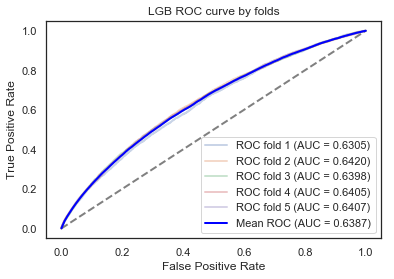

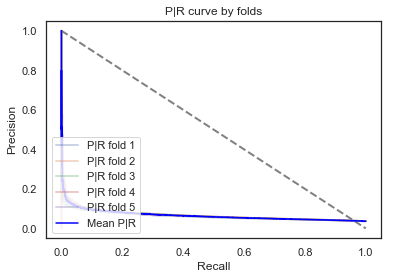

<Figure size 432x288 with 0 Axes>

In [66]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score, roc_auc_score, f1_score, roc_curve, auc,precision_recall_curve
from scipy import interp
nfold = 5
skf = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=42)

oof = np.zeros(len(train_df))
mean_fpr = np.linspace(0,1,100)
cms= []
tprs = []
aucs = []
y_real = []
y_proba = []
recalls = []
roc_aucs = []
f1_scores = []
accuracies = []
precisions = []
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

i = 1
for train_idx, valid_idx in skf.split(train_df, train_df.target.values):
    print("\nfold {}".format(i))
    trn_data = lgb.Dataset(train_df.iloc[train_idx][features].values,
                                   label=train_df.iloc[train_idx][target].values
                                   )
    val_data = lgb.Dataset(train_df.iloc[valid_idx][features].values,
                                   label=train_df.iloc[valid_idx][target].values
                                   )   
    
    clf = lgb.train(param_lgb, trn_data, num_boost_round = 500, valid_sets = [trn_data, val_data], verbose_eval = 100, early_stopping_rounds = 100)
    oof[valid_idx] = clf.predict(train_df.iloc[valid_idx][features].values) 
    
    predictions += clf.predict(test_df[features]) / nfold
    
    # Scores 
    roc_aucs.append(roc_auc_score(train_df.iloc[valid_idx][target].values, oof[valid_idx]))
    accuracies.append(accuracy_score(train_df.iloc[valid_idx][target].values, oof[valid_idx].round()))
    recalls.append(recall_score(train_df.iloc[valid_idx][target].values, oof[valid_idx].round()))
    precisions.append(precision_score(train_df.iloc[valid_idx][target].values ,oof[valid_idx].round()))
    f1_scores.append(f1_score(train_df.iloc[valid_idx][target].values, oof[valid_idx].round()))
    
    # Roc curve by folds
    f = plt.figure(1)
    fpr, tpr, t = roc_curve(train_df.iloc[valid_idx][target].values, oof[valid_idx])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.4f)' % (i,roc_auc))
    
    # Precion recall by folds
    g = plt.figure(2)
    precision, recall, _ = precision_recall_curve(train_df.iloc[valid_idx][target].values, oof[valid_idx])
    y_real.append(train_df.iloc[valid_idx][target].values)
    y_proba.append(oof[valid_idx])
    plt.plot(recall, precision, lw=2, alpha=0.3, label='P|R fold %d' % (i))  
    
    i= i+1
    
    # Confusion matrix by folds
    cms.append(confusion_matrix(train_df.iloc[valid_idx][target].values, oof[valid_idx].round()))
    
    # Features imp
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = nfold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

# Metrics
print(
        '\nCV roc score        : {0:.4f}, std: {1:.4f}.'.format(np.mean(roc_aucs), np.std(roc_aucs)),
        '\nCV accuracy score   : {0:.4f}, std: {1:.4f}.'.format(np.mean(accuracies), np.std(accuracies)),
        '\nCV recall score     : {0:.4f}, std: {1:.4f}.'.format(np.mean(recalls), np.std(recalls)),
        '\nCV precision score  : {0:.4f}, std: {1:.4f}.'.format(np.mean(precisions), np.std(precisions)),
        '\nCV f1 score         : {0:.4f}, std: {1:.4f}.'.format(np.mean(f1_scores), np.std(f1_scores))
)

#ROC 
f = plt.figure(1)
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'grey')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.4f)' % (np.mean(roc_aucs)),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LGB ROC curve by folds')
plt.legend(loc="lower right")

# PR plt
g = plt.figure(2)
plt.plot([0,1],[1,0],linestyle = '--',lw = 2,color = 'grey')
y_real = np.concatenate(y_real)
y_proba = np.concatenate(y_proba)
precision, recall, _ = precision_recall_curve(y_real, y_proba)
plt.plot(recall, precision, color='blue',
         label=r'Mean P|R')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('P|R curve by folds')
plt.legend(loc="lower left")

# Confusion maxtrix & metrics
plt.rcParams["axes.grid"] = False
cm = np.average(cms, axis=0)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title= 'LGB Confusion matrix [averaged/folds]')
plt.show()

In [67]:
sample_submission = pd.read_csv(path+'input/sample_submission.csv')
sample_submission.head()

,id,target
0,0,0.0364
1,1,0.0364
2,2,0.0364
3,3,0.0364
4,4,0.0364


#### 贝叶斯调参得分原始特征：0.28375  0.27854

In [70]:
sample_submission['target'] = predictions
sample_submission.to_csv('submission_porto.csv',index=False)

In [28]:
model = lgb.LGBMClassifier(
        boosting_type="gbdt", num_leaves=15, reg_alpha=0, reg_lambda=0.,
    max_depth=-1, n_estimators=1500, objective='binary',metric= 'F1',
    subsample=0.95, colsample_bytree=0.95, subsample_freq=1,
    learning_rate=0.05, random_state=2017
    )

In [29]:
#5折交叉验证
from sklearn.model_selection import KFold
n_splits=5
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

train_x = data[data['target']!=-1][feats]
train_y = data[data['target']!=-1]['target']
res=data[data['target']==-1][['target']]

test_x= data[data['target']==-1][feats]
res['target'] = 0
for train_idx, val_idx in kfold.split(train_x):
    model.random_state = model.random_state + 1
    train_x1 = train_x.loc[train_idx]
    train_y1 = train_y.loc[train_idx]
    test_x1 = train_x.loc[val_idx]
    test_y1 = train_y.loc[val_idx]
    #,(vali_x,vali_y)
    model.fit(train_x1, train_y1,eval_set=[(train_x1, train_y1),(test_x1, test_y1)],eval_metric='auc',early_stopping_rounds=100)#categorical_feature=categorical_features
    res['target'] += model.predict_proba(test_x)[:,1]

res['target'] = res['target']/5
target_mean = np.mean(res['target'])


[1]	training's auc: 0.600262	valid_1's auc: 0.599704
Training until validation scores don't improve for 100 rounds.
[2]	training's auc: 0.609987	valid_1's auc: 0.609663
[3]	training's auc: 0.614092	valid_1's auc: 0.613019
[4]	training's auc: 0.617818	valid_1's auc: 0.616907
[5]	training's auc: 0.61739	valid_1's auc: 0.616479
[6]	training's auc: 0.619622	valid_1's auc: 0.618545
[7]	training's auc: 0.620133	valid_1's auc: 0.618537
[8]	training's auc: 0.622498	valid_1's auc: 0.620238
[9]	training's auc: 0.623475	valid_1's auc: 0.621206
[10]	training's auc: 0.624146	valid_1's auc: 0.621479
[11]	training's auc: 0.625223	valid_1's auc: 0.622564
[12]	training's auc: 0.627022	valid_1's auc: 0.624177
[13]	training's auc: 0.627703	valid_1's auc: 0.624475
[14]	training's auc: 0.629145	valid_1's auc: 0.625564
[15]	training's auc: 0.630294	valid_1's auc: 0.626302
[16]	training's auc: 0.630828	valid_1's auc: 0.626847
[17]	training's auc: 0.631208	valid_1's auc: 0.626959
[18]	training's auc: 0.631984

[300]	training's auc: 0.692612	valid_1's auc: 0.640717
[301]	training's auc: 0.692702	valid_1's auc: 0.640669
[302]	training's auc: 0.692918	valid_1's auc: 0.640588
[303]	training's auc: 0.69296	valid_1's auc: 0.64057
[304]	training's auc: 0.693052	valid_1's auc: 0.640522
[305]	training's auc: 0.693236	valid_1's auc: 0.64053
[306]	training's auc: 0.693384	valid_1's auc: 0.640558
[307]	training's auc: 0.693567	valid_1's auc: 0.64057
Early stopping, best iteration is:
[207]	training's auc: 0.676009	valid_1's auc: 0.641354
[1]	training's auc: 0.603849	valid_1's auc: 0.595176
Training until validation scores don't improve for 100 rounds.
[2]	training's auc: 0.61177	valid_1's auc: 0.605107
[3]	training's auc: 0.618683	valid_1's auc: 0.612601
[4]	training's auc: 0.619208	valid_1's auc: 0.613519
[5]	training's auc: 0.620953	valid_1's auc: 0.615649
[6]	training's auc: 0.621555	valid_1's auc: 0.615892
[7]	training's auc: 0.62199	valid_1's auc: 0.616432
[8]	training's auc: 0.623461	valid_1's auc

[142]	training's auc: 0.665304	valid_1's auc: 0.635253
[143]	training's auc: 0.665555	valid_1's auc: 0.635208
[144]	training's auc: 0.665732	valid_1's auc: 0.635193
[145]	training's auc: 0.665828	valid_1's auc: 0.635241
[146]	training's auc: 0.666035	valid_1's auc: 0.635302
[147]	training's auc: 0.666227	valid_1's auc: 0.635287
[148]	training's auc: 0.666375	valid_1's auc: 0.635268
[149]	training's auc: 0.666643	valid_1's auc: 0.63526
[150]	training's auc: 0.666762	valid_1's auc: 0.635205
[151]	training's auc: 0.666841	valid_1's auc: 0.635165
[152]	training's auc: 0.667194	valid_1's auc: 0.635241
[153]	training's auc: 0.667437	valid_1's auc: 0.635236
[154]	training's auc: 0.667622	valid_1's auc: 0.635205
[155]	training's auc: 0.667782	valid_1's auc: 0.635146
[156]	training's auc: 0.668018	valid_1's auc: 0.635307
[157]	training's auc: 0.668187	valid_1's auc: 0.635294
[158]	training's auc: 0.668349	valid_1's auc: 0.635314
[159]	training's auc: 0.668532	valid_1's auc: 0.635268
[160]	train

[148]	training's auc: 0.664828	valid_1's auc: 0.646034
[149]	training's auc: 0.664996	valid_1's auc: 0.64604
[150]	training's auc: 0.665121	valid_1's auc: 0.646073
[151]	training's auc: 0.665262	valid_1's auc: 0.64607
[152]	training's auc: 0.665518	valid_1's auc: 0.646135
[153]	training's auc: 0.665742	valid_1's auc: 0.646182
[154]	training's auc: 0.665916	valid_1's auc: 0.646195
[155]	training's auc: 0.666134	valid_1's auc: 0.646332
[156]	training's auc: 0.666407	valid_1's auc: 0.64629
[157]	training's auc: 0.666541	valid_1's auc: 0.646326
[158]	training's auc: 0.666725	valid_1's auc: 0.646221
[159]	training's auc: 0.666854	valid_1's auc: 0.646228
[160]	training's auc: 0.667169	valid_1's auc: 0.646183
[161]	training's auc: 0.667354	valid_1's auc: 0.64619
[162]	training's auc: 0.667539	valid_1's auc: 0.646181
[163]	training's auc: 0.667657	valid_1's auc: 0.646112
[164]	training's auc: 0.66782	valid_1's auc: 0.64609
[165]	training's auc: 0.667994	valid_1's auc: 0.646054
[166]	training's

[190]	training's auc: 0.674331	valid_1's auc: 0.635737
[191]	training's auc: 0.674538	valid_1's auc: 0.635731
[192]	training's auc: 0.674843	valid_1's auc: 0.635689
[193]	training's auc: 0.675074	valid_1's auc: 0.635741
[194]	training's auc: 0.675312	valid_1's auc: 0.635673
[195]	training's auc: 0.67548	valid_1's auc: 0.635757
[196]	training's auc: 0.675692	valid_1's auc: 0.63578
[197]	training's auc: 0.675852	valid_1's auc: 0.635827
[198]	training's auc: 0.675992	valid_1's auc: 0.635809
[199]	training's auc: 0.676276	valid_1's auc: 0.635794
[200]	training's auc: 0.67643	valid_1's auc: 0.63584
[201]	training's auc: 0.676659	valid_1's auc: 0.635857
[202]	training's auc: 0.676916	valid_1's auc: 0.63583
[203]	training's auc: 0.677116	valid_1's auc: 0.635866
[204]	training's auc: 0.67721	valid_1's auc: 0.635879
[205]	training's auc: 0.67737	valid_1's auc: 0.635968
[206]	training's auc: 0.677625	valid_1's auc: 0.635936
[207]	training's auc: 0.677776	valid_1's auc: 0.635961
[208]	training's 

[488]	training's auc: 0.717649	valid_1's auc: 0.637116
[489]	training's auc: 0.717863	valid_1's auc: 0.637071
[490]	training's auc: 0.717979	valid_1's auc: 0.637032
[491]	training's auc: 0.718107	valid_1's auc: 0.637098
[492]	training's auc: 0.718177	valid_1's auc: 0.637048
[493]	training's auc: 0.718265	valid_1's auc: 0.637031
[494]	training's auc: 0.718384	valid_1's auc: 0.637077
[495]	training's auc: 0.718568	valid_1's auc: 0.637013
[496]	training's auc: 0.71861	valid_1's auc: 0.637012
[497]	training's auc: 0.718718	valid_1's auc: 0.637055
[498]	training's auc: 0.718799	valid_1's auc: 0.637043
[499]	training's auc: 0.718833	valid_1's auc: 0.6371
[500]	training's auc: 0.71888	valid_1's auc: 0.637117
[501]	training's auc: 0.718948	valid_1's auc: 0.637143
[502]	training's auc: 0.719088	valid_1's auc: 0.637146
[503]	training's auc: 0.719155	valid_1's auc: 0.637116
[504]	training's auc: 0.719176	valid_1's auc: 0.637112
[505]	training's auc: 0.719278	valid_1's auc: 0.637148
[506]	training

[179]	training's auc: 0.672459	valid_1's auc: 0.63575
[180]	training's auc: 0.672581	valid_1's auc: 0.635701
[181]	training's auc: 0.672884	valid_1's auc: 0.63567
[182]	training's auc: 0.672986	valid_1's auc: 0.635652
[183]	training's auc: 0.673127	valid_1's auc: 0.635679
[184]	training's auc: 0.673309	valid_1's auc: 0.635687
[185]	training's auc: 0.673635	valid_1's auc: 0.635691
[186]	training's auc: 0.673742	valid_1's auc: 0.635657
[187]	training's auc: 0.673925	valid_1's auc: 0.635751
[188]	training's auc: 0.674249	valid_1's auc: 0.635773
[189]	training's auc: 0.674395	valid_1's auc: 0.635838
[190]	training's auc: 0.674589	valid_1's auc: 0.635794
[191]	training's auc: 0.674683	valid_1's auc: 0.635788
[192]	training's auc: 0.67505	valid_1's auc: 0.635768
[193]	training's auc: 0.67538	valid_1's auc: 0.63576
[194]	training's auc: 0.675539	valid_1's auc: 0.635774
[195]	training's auc: 0.675654	valid_1's auc: 0.635733
[196]	training's auc: 0.675825	valid_1's auc: 0.635741
[197]	training'

In [30]:
pd.DataFrame({'id':data[data['target']==-1]['id'],'target':res['target']}).to_csv(path+'output/lgb_proba{}.csv'.format(target_mean),index=False)

In [8]:
print(target_mean)

NameError: name 'target_mean' is not defined

In [36]:
train_label.value_counts()

0.0    573518
1.0     21694
Name: target, dtype: int64

In [45]:
train_label.target.isnull().sum()

892816

In [9]:
train_label = data[data['target']!=-1][['target']]
train_label['target']=train_label['target'].astype('int')

In [21]:
train = data[data['target']!=-1].fillna(0)
train_label = data[data['target']!=-1]['target']
test = data[data['target']==-1].fillna(0)
train_list = train[feats]
test_list = test[feats]
test_id =data[data['target']==-1]['id']

In [22]:
type(train_list)

pandas.core.frame.DataFrame

In [25]:
import lightgbm as lgbm
from scipy import sparse as ssp
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
NFOLDS = 5
kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=218)
cv_only = True
save_cv = True
full_train = False
from scipy import sparse as ssp

def Gini(y_true, y_pred):
    # check and get number of samples
    assert y_true.shape == y_pred.shape
    n_samples = y_true.shape[0]

    # sort rows on prediction column
    # (from largest to smallest)
    arr = np.array([y_true, y_pred]).transpose()
    true_order = arr[arr[:, 0].argsort()][::-1, 0]
    pred_order = arr[arr[:, 1].argsort()][::-1, 0]

    # get Lorenz curves
    L_true = np.cumsum(true_order) * 1. / np.sum(true_order)
    L_pred = np.cumsum(pred_order) * 1. / np.sum(pred_order)
    L_ones = np.linspace(1 / n_samples, 1, n_samples)

    # get Gini coefficients (area between curves)
    G_true = np.sum(L_ones - L_true)
    G_pred = np.sum(L_ones - L_pred)

    # normalize to true Gini coefficient
    return G_pred * 1. / G_true

cv_only = True
save_cv = True
full_train = False

def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    return 'gini', Gini(labels, preds), True

X = ssp.csr_matrix(train_list)
X_test = ssp.csr_matrix(test_list)

# X = ssp.hstack(train_list).tocsr()
# X_test = ssp.hstack(test_list).tocsr()
# X = train_list
# X_test = test_list
learning_rate = 0.1
num_leaves = 15
min_data_in_leaf = 2000
feature_fraction = 0.6
num_boost_round = 10000
params = {"objective": "binary",
          "boosting_type": "gbdt",
          "learning_rate": learning_rate,
          "num_leaves": num_leaves,
           "max_bin": 256,
          "feature_fraction": feature_fraction,
          "verbosity": 0,
          "drop_rate": 0.1,
          "is_unbalance": False,
          "max_drop": 50,
          "min_child_samples": 10,
          "min_child_weight": 150,
          "min_split_gain": 0,
          "subsample": 0.9
          }

x_score = []
final_cv_train = np.zeros(len(train_label))
final_cv_pred = np.zeros(len(test_id))
for s in range(16):
    cv_train = np.zeros(len(train_label))
    cv_pred = np.zeros(len(test_id))

    params['seed'] = s

    if cv_only:
        kf = kfold.split(X, train_label)

        best_trees = []
        fold_scores = []

        for i, (train_fold, validate) in enumerate(kf):
            X_train, X_validate, label_train, label_validate = \
                X[train_fold, :], X[validate, :], train_label[train_fold], train_label[validate]
            dtrain = lgbm.Dataset(X_train, label_train)
            dvalid = lgbm.Dataset(X_validate, label_validate, reference=dtrain)
            bst = lgbm.train(params, dtrain, num_boost_round, valid_sets=dvalid, feval=evalerror, verbose_eval=100,
                            early_stopping_rounds=100)
            best_trees.append(bst.best_iteration)
            cv_pred += bst.predict(X_test, num_iteration=bst.best_iteration)
            cv_train[validate] += bst.predict(X_validate)

            score = Gini(label_validate, cv_train[validate])
            print (score)
            fold_scores.append(score)

        cv_pred /= NFOLDS
        final_cv_train += cv_train
        final_cv_pred += cv_pred

        print("cv score:")
        print (Gini(train_label, cv_train))
        print ("current score:", Gini(train_label, final_cv_train / (s + 1.)), s+1)
        print(fold_scores)
        print(best_trees, np.mean(best_trees))

        x_score.append(Gini(train_label, cv_train))

print(x_score)
pd.DataFrame({'id': test_id, 'target': final_cv_pred / 16.}).to_csv('./model/lgbm3_pred_avg.csv', index=False)
# pd.DataFrame({'id': train_id, 'target': final_cv_train / 16.}).to_csv('./model/lgbm3_cv_avg.csv', index=False)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.151634	valid_0's gini: 0.286522
[200]	valid_0's binary_logloss: 0.151663	valid_0's gini: 0.284746
Early stopping, best iteration is:
[124]	valid_0's binary_logloss: 0.151608	valid_0's gini: 0.287197
0.2871968044984855
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.15226	valid_0's gini: 0.270299
[200]	valid_0's binary_logloss: 0.152268	valid_0's gini: 0.271789
[300]	valid_0's binary_logloss: 0.152358	valid_0's gini: 0.270892
Early stopping, best iteration is:
[223]	valid_0's binary_logloss: 0.152241	valid_0's gini: 0.27318
0.27318020251916236
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.152069	valid_0's gini: 0.280359
[200]	valid_0's binary_logloss: 0.152039	valid_0's gini: 0.28127
[300]	valid_0's binary_logloss: 0.152077	valid_0's gini: 0.279999
Early stopping, best iteration is:
[227]	vali

[200]	valid_0's binary_logloss: 0.152101	valid_0's gini: 0.279633
[300]	valid_0's binary_logloss: 0.152164	valid_0's gini: 0.278069
Early stopping, best iteration is:
[213]	valid_0's binary_logloss: 0.152077	valid_0's gini: 0.280582
0.2805820332292268
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.151871	valid_0's gini: 0.280531
[200]	valid_0's binary_logloss: 0.151874	valid_0's gini: 0.280028
Early stopping, best iteration is:
[144]	valid_0's binary_logloss: 0.151815	valid_0's gini: 0.281862
0.2818618306150736
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.151749	valid_0's gini: 0.284237
Early stopping, best iteration is:
[89]	valid_0's binary_logloss: 0.151717	valid_0's gini: 0.285277
0.28527727312689655
cv score:
0.28121368704591365
current score: 0.2844193403326682 10
[0.289985336085231, 0.26878960754273146, 0.2805820332292268, 0.2818618306150736, 0.28527727312689655]
[165, 155, 213,

[212]	valid_0's binary_logloss: 0.151532	valid_0's gini: 0.290199
0.29019937237133153
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.152256	valid_0's gini: 0.269684
[200]	valid_0's binary_logloss: 0.152287	valid_0's gini: 0.270168
Early stopping, best iteration is:
[126]	valid_0's binary_logloss: 0.152225	valid_0's gini: 0.271252
0.2712524413469931
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.152197	valid_0's gini: 0.278146
[200]	valid_0's binary_logloss: 0.152154	valid_0's gini: 0.279347
[300]	valid_0's binary_logloss: 0.152172	valid_0's gini: 0.279633
Early stopping, best iteration is:
[238]	valid_0's binary_logloss: 0.152127	valid_0's gini: 0.28012
0.28011998039239067
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.151797	valid_0's gini: 0.283019
[200]	valid_0's binary_logloss: 0.15186	valid_0's gini: 0.280483
Early stopping, best ite

NameError: name 'train_id' is not defined

In [ ]:
#统计数据中==-1的个数
data['missing'] = (data==-1).sum(axis=1).astype(float)
def encode_onehot(df,column_name):
    feature_df=pd.get_dummies(df[column_name], prefix=column_name)
    all = pd.concat([df.drop([column_name], axis=1),feature_df], axis=1)
    return all
for i in categorical_features:
    data = encode_onehot(data,i)



ind_features = [c for c in features if 'ind' in c]
count=0
for c in ind_features:
    if count==0:
        data['new_ind'] = data[c].astype(str)+'_'
        count+=1
    else:
        data['new_ind'] += data[c].astype(str)+'_'


cat_count_features = []
for c in categorical_features+['new_ind']:
    d = data[c].value_counts().to_dict()
    data['%s_count'%c] = data[c].apply(lambda x:d.get(x,0))
    cat_count_features.append('%s_count'%c)
del data['new_ind']

# cat_col = categorical_features
# for i in tqdm_notebook(cat_col):
# #     lbl = LabelEncoder()
#     data['count_' + i] = data.groupby([i])[i].transform('count')
# #     data[i] = lbl.fit_transform(data[i].astype(str))